In [1]:
!nvidia-smi

Sat Nov 26 22:06:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!git clone https://github.com/gnobitab/FuseDream.git
!pip install ftfy regex tqdm numpy scipy h5py lpips==0.1.4
!pip install git+https://github.com/openai/CLIP.git
!pip install gdown
!gdown 'https://drive.google.com/uc?id=17ymX6rhsgHDZw_g5XgAFW4xLSDocARCM'
!gdown 'https://drive.google.com/uc?id=1sOZ9og9kJLsqMNhaDnPJgzVsBZQ1sjZ5'

Cloning into 'FuseDream'...
remote: Enumerating objects: 124, done.
remote: Total 124 (delta 0), reused 0 (delta 0), pack-reused 124
Receiving objects: 100% (124/124), 8.24 MiB | 5.05 MiB/s, done.
Resolving deltas: 100% (40/40), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 1.1 MB/s 
     |████████████████████████████████| 53 kB 2.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-e1jj8q58
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-e1jj8q58
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369408 sha256=28d7cd1ced56faa4e657a316e45609a222cca96512bbae9ddcedfa89d411f87b
  Stored in directory: /tmp/pip-ephem-wheel-cache-lou85xme/wheels/fd/b9/c3/5b4470e35ed76e174bff77c92f91da82098d5e35fd5bc8cdac
Successfully 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import os
import shutil
shutil.copy("/content/drive/MyDrive/vlr/biggan-256.pth", './BigGAN_utils/weights/biggan-256.pth')

'./BigGAN_utils/weights/biggan-256.pth'

In [12]:
!ls
# !cp biggan-256.pth FuseDream/BigGAN_utils/weights/
# !cp biggan-512.pth FuseDream/BigGAN_utils/weights/
%cd FuseDream

drive  FuseDream  sample_data
cp: cannot stat 'biggan-256.pth': No such file or directory
cp: cannot stat 'biggan-512.pth': No such file or directory
/content/FuseDream


In [13]:
import torch
from tqdm import tqdm
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import torchvision
import BigGAN_utils.utils as utils
import clip
import torch.nn.functional as F
from DiffAugment_pytorch import DiffAugment
import numpy as np
from fusedream_utils import FuseDreamBaseGenerator, get_G, save_image

In [26]:
#@title Parameters
SENTENCE = "packet with branded slogans by Google" #@param {type:"string"}
INIT_ITERS =  500#@param {type:"number"}
OPT_ITERS = 500#@param {type:"number"}
NUM_BASIS = 5#@param {type:"number"}
MODEL = "biggan-256" #@param ["biggan-256","biggan-512"]
SEED = 0#@param {type:"number"}

import sys
sys.argv = [''] ### workaround to deal with the argparse in Jupyter

Generating: packet with branded slogans by Google
[8, 16, 32, 64, 128, 256] {8: False, 16: False, 32: False, 64: False, 128: True, 256: False}
Adding attention layer in G at resolution 128
Number of parameters: 82097604


100%|██████████| 500/500 [02:01<00:00,  4.10it/s]


AugCLIP score: 0.36490478515625


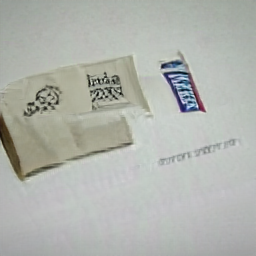

In [27]:
### Generation: Click the 'run' button and the final generated image will be shown after the end of the algorithm
utils.seed_rng(SEED) 

sentence = SENTENCE

print('Generating:', sentence)
if MODEL == "biggan-256":
    G, config = get_G(256) 
elif MODEL == "biggan-512":
    G, config = get_G(512) 
else:
    raise Exception('Model not supported')
generator = FuseDreamBaseGenerator(G, config, 10) 
z_cllt, y_cllt = generator.generate_basis(sentence, init_iters=INIT_ITERS, num_basis=NUM_BASIS)

z_cllt_save = torch.cat(z_cllt).cpu().numpy()
y_cllt_save = torch.cat(y_cllt).cpu().numpy()
img, z, y = generator.optimize_clip_score(z_cllt, y_cllt, sentence, latent_noise=False, augment=True, opt_iters=OPT_ITERS, optimize_y=True)
### Set latent_noise = True yields slightly higher AugCLIP score, but slightly lower image quality. We set it to False for dogs.
score = generator.measureAugCLIP(z, y, sentence, augment=True, num_samples=20)
print('AugCLIP score:', score)
import os
if not os.path.exists('./samples'):
    os.mkdir('./samples')
save_image(img, 'samples/fusedream_%s_seed_%d_score_%.4f.png'%(sentence, SEED, score))

from IPython import display
display.display(display.Image('samples/fusedream_%s_seed_%d_score_%.4f.png'%(sentence, SEED, score)))